## Finding Correlation and sorting all (campaign 1) light curves used in Aranzana et al. (cont.)

In [1]:
%matplotlib inline
#from itertools import izip # because we all love generators
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import leastsq
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram, cophenet
from scipy.spatial.distance import pdist
import richardsplot as rplot # for nicer plots

# not trying to mess around in jack's folder until it's finished
import sys 
sys.path.append('./CARMA')

from utilities.downloads import urls
from utilities.downloads.downloader import fits_downloader

/home/rachel/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Functions we defined last time

In [2]:
def split_lc(t, f):
    '''
    Function to split light curves at the discontinuity (halfway point)
    '''
    split = min(t) + (max(t)-min(t))/2
    t1 = t[t<split]
    t2 = t[t>=split]
    f1 = f[t<split]
    f2 = f[t>=split]
    return t1, f1, t2, f2

def subtract_sine(t, f):
    '''
    Function that will fit and subtract a sine curve (with 372.53 day period) from data
    '''

    period = 372.53
    omega = 2*np.pi/period
    #sin_func = lambda x: x[0]*np.sin(omega*t+x[1]) + x[2] - f # function to fit
    
    def sin_func(x):
        '''
        Function to minimize (returns difference of sin curve and data)
        '''
        return x[0]*np.sin(omega*t+x[1]) + x[2] - f
    
    
    # intial guess
    guess_amp = 1.
    guess_phase = 1.
    guess_mean = 1.
    
    # least squares fit
    est = leastsq(sin_func, [guess_amp, guess_phase, guess_mean])[0]
    
    # subtract the fit
    new_f = f -(est[0]*np.sin(omega*t+est[1])+est[2])
    
    return t, new_f

def detrend(t, f):
    '''
    Function to spilt data, subtract sine curve and return the detrended data, split at the discontinuity
    '''
    # split at the discontinuity
    t1,f1, t2,f2 = split_lc(t, f)
    
    # subract sine fit (de-trending) piecewise
    t1, f1 = subtract_sine(t1, f1)
    t2, f2 = subtract_sine(t2, f2)
    
    return t1,f1, t2,f2 
    

def norm_xcorr(a, v):
    '''
    Compute the normalized cross-correlation (lag plot)
    '''
    a = (a - np.mean(a)) / (np.std(a) * len(a))
    v = (v - np.mean(v)) /  np.std(v)
    
    return np.correlate(a, v, mode='full')


def interp_missing(c, f, gap=None):
    '''
    Function to "interpolate" all the missing cadence points 
    '''
    missing_c = np.setdiff1d(range(min(c), max(c)+1), c)
    
    # incorporate mid campaign gap if necessary
    if gap is not None: missing_c = missing_c[np.logical_not(np.isin(missing_c, gap))]
    
    
    for cm in missing_c:
        # get index right after "missing" time value
        ind = np.argwhere(c > cm)[0]
        # interpolate the "missing" corrected flux values (take the average--linear interp)
        missing_f = (f[ind-1] + f[ind])/2.0
        
        # insert them into the correct locations in the arrays
        f = np.insert(f, ind, missing_f)
        c = np.insert(c, ind, cm)
    
    return c, f

### Download data using Jack's code
Jack's module contains functions that will download/open fits files from MAST's servers.

In [3]:
# EPIC IDs (Investigation ID: GO1035)
with open('GO1035_epics.csv') as f: lines = f.readlines() # put them in a csv rather than typing it out 
epic_ids = [int(line.strip()) for line in lines] # take care of whitespace

    
# the ones in Figure B1 are all from camapaign 1 
campaign = 1

# create MAST urls
everest_urls = [urls.everest(epicid, campaign) for epicid in epic_ids]
sff_urls = [urls.sff(epicid, campaign) for epicid in epic_ids]

In [4]:
# Download

#everest_files = list(fits_downloader(everest_urls, ordered=True)) # doesn't work right now, getting error
# following are missing from everest: 201240157, 201219871, 201219689, 201184312 (potentially others)

sff_files = list(fits_downloader(sff_urls, ordered=True)) 

### Write it to a pandas data frame
We're compiling everything into a data frame so that it's easier to access. Each row represents a different object.

The columns are as follows:
* cad - list of cadence numbers of observations
* flux - list of observed/corrected flux (Vanderburg & Johnson)
* cad pre - a list containing the cadence numbers (before the mid-campaign observation gap)
* cad post - a list containing the cadence numbers (after the mid-campaign observation gap)
* flux pre -  a list containing the fluxes (before the mid-campaign observation gap)
* flux post -  a list containing the fluxes (after the mid-campaign observation gap)

In [5]:
# detred them all first and put them in a dataframe as our "clean" data
sff_data = {'epic':[], 'cad':[], 'flux':[], 'cad pre':[], 'cad post':[], 'flux pre':[], 'flux post':[]}
for i, agn in enumerate(sff_files):
    c = agn['BESTAPER'].data['CADENCENO']
    f = agn['BESTAPER'].data['FCOR']
    
    # interpolate missing points
    mid_gap = range(93280+1, 93421)
    c, f = interp_missing(c, f, gap=mid_gap)
    
    # split and detrend
    c_l, f_l, c_r, f_r = detrend(c, f)
    
    c_new = np.concatenate([c_l, c_r])
    f_new = np.concatenate([f_l, f_r])
    
    # append the data to the dataframe
    sff_data['epic'].append(epic_ids[i])
    
    sff_data['cad'].append(c_new)
    sff_data['flux'].append(f_new)
    
    sff_data['cad pre'].append(c_l)
    sff_data['cad post'].append(c_r)
    sff_data['flux pre'].append(f_l)
    sff_data['flux post'].append(f_r)
    
sff_df = pd.DataFrame(sff_data) # try it as a dataframe

### Calculate correlation
We're creating a matrix that contains the correlation coefficients for all the light curves (comparing them to each other). The objects are represented by the indexing of the row/col.

In [80]:
# put all the correlation coefficients in a matrix
corr_all = np.zeros((len(sff_files), len(sff_files)))

# forgive me god, for all these damn for loops
for i, row0 in sff_df.iterrows():
    
    # extract flux values after discontinuity
    flux0 = row0['flux post']
    
    for j, row1 in sff_df.iterrows():
        
        # extract flux values after discontinuity
        flux1 = row1['flux post']
        
        # calculate correlation
        #corr = pd.DataFrame(flux0)[0].corr(pd.DataFrame(flux1)[0], method='spearman')
        
        # calculate the maximum value of cross correlation
        corr = np.max(norm_xcorr(flux0, flux1))
        
        # write to matrix
        corr_all[i,j] = corr

# sanity check (there should be 1's on the diagonal)
print(corr_all)

### Correlation Clustering
We want to separate them into "similar" groups using our correlation coefficients. We're just going to use scipy's clustering capabilities.

In [90]:
# generate the linkage matrix
# method arg was chosen thru trial and error, trying to maximize Cophenetic correlation coefficient
Z = linkage(corr_all, method='average') 

# check how well it performed using Cophenetic corr coeff (closer to 1 is better)
coph, coph_dists = cophenet(Z, pdist(corr_all))
print ("Cophenetic Correlation coefficient = %s" %coph)

# set threshold for clustering
threshold = 1.5

# get clusters
clusters = fcluster(Z, threshold, criterion='distance', depth=8)
print ("Found %s different light curve groups."%len(np.unique(clusters)))

Cophenetic Correlation coefficient = 0.7700470335639795
Found 26 different light curve groups.


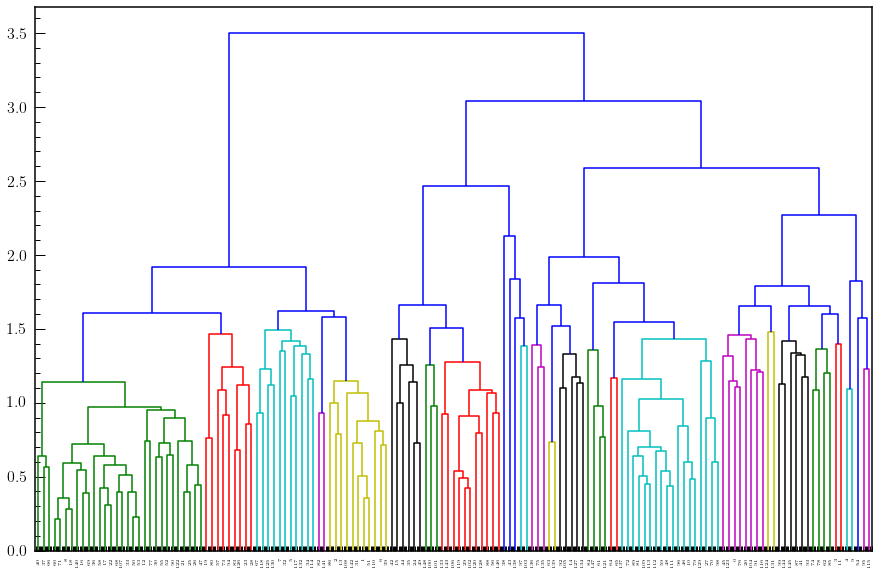

In [85]:
fig, axs = plt.subplots(figsize=(15, 10))

dend = dendrogram(Z, ax = axs, color_threshold=threshold)

The dendrogram show us what our groups look like for a given threshold. Plot them in these different groups where groups are distinguishable by color. 

**Note:** The plotted colors do *not* necessarily correspond to the ones in the dendrogram.

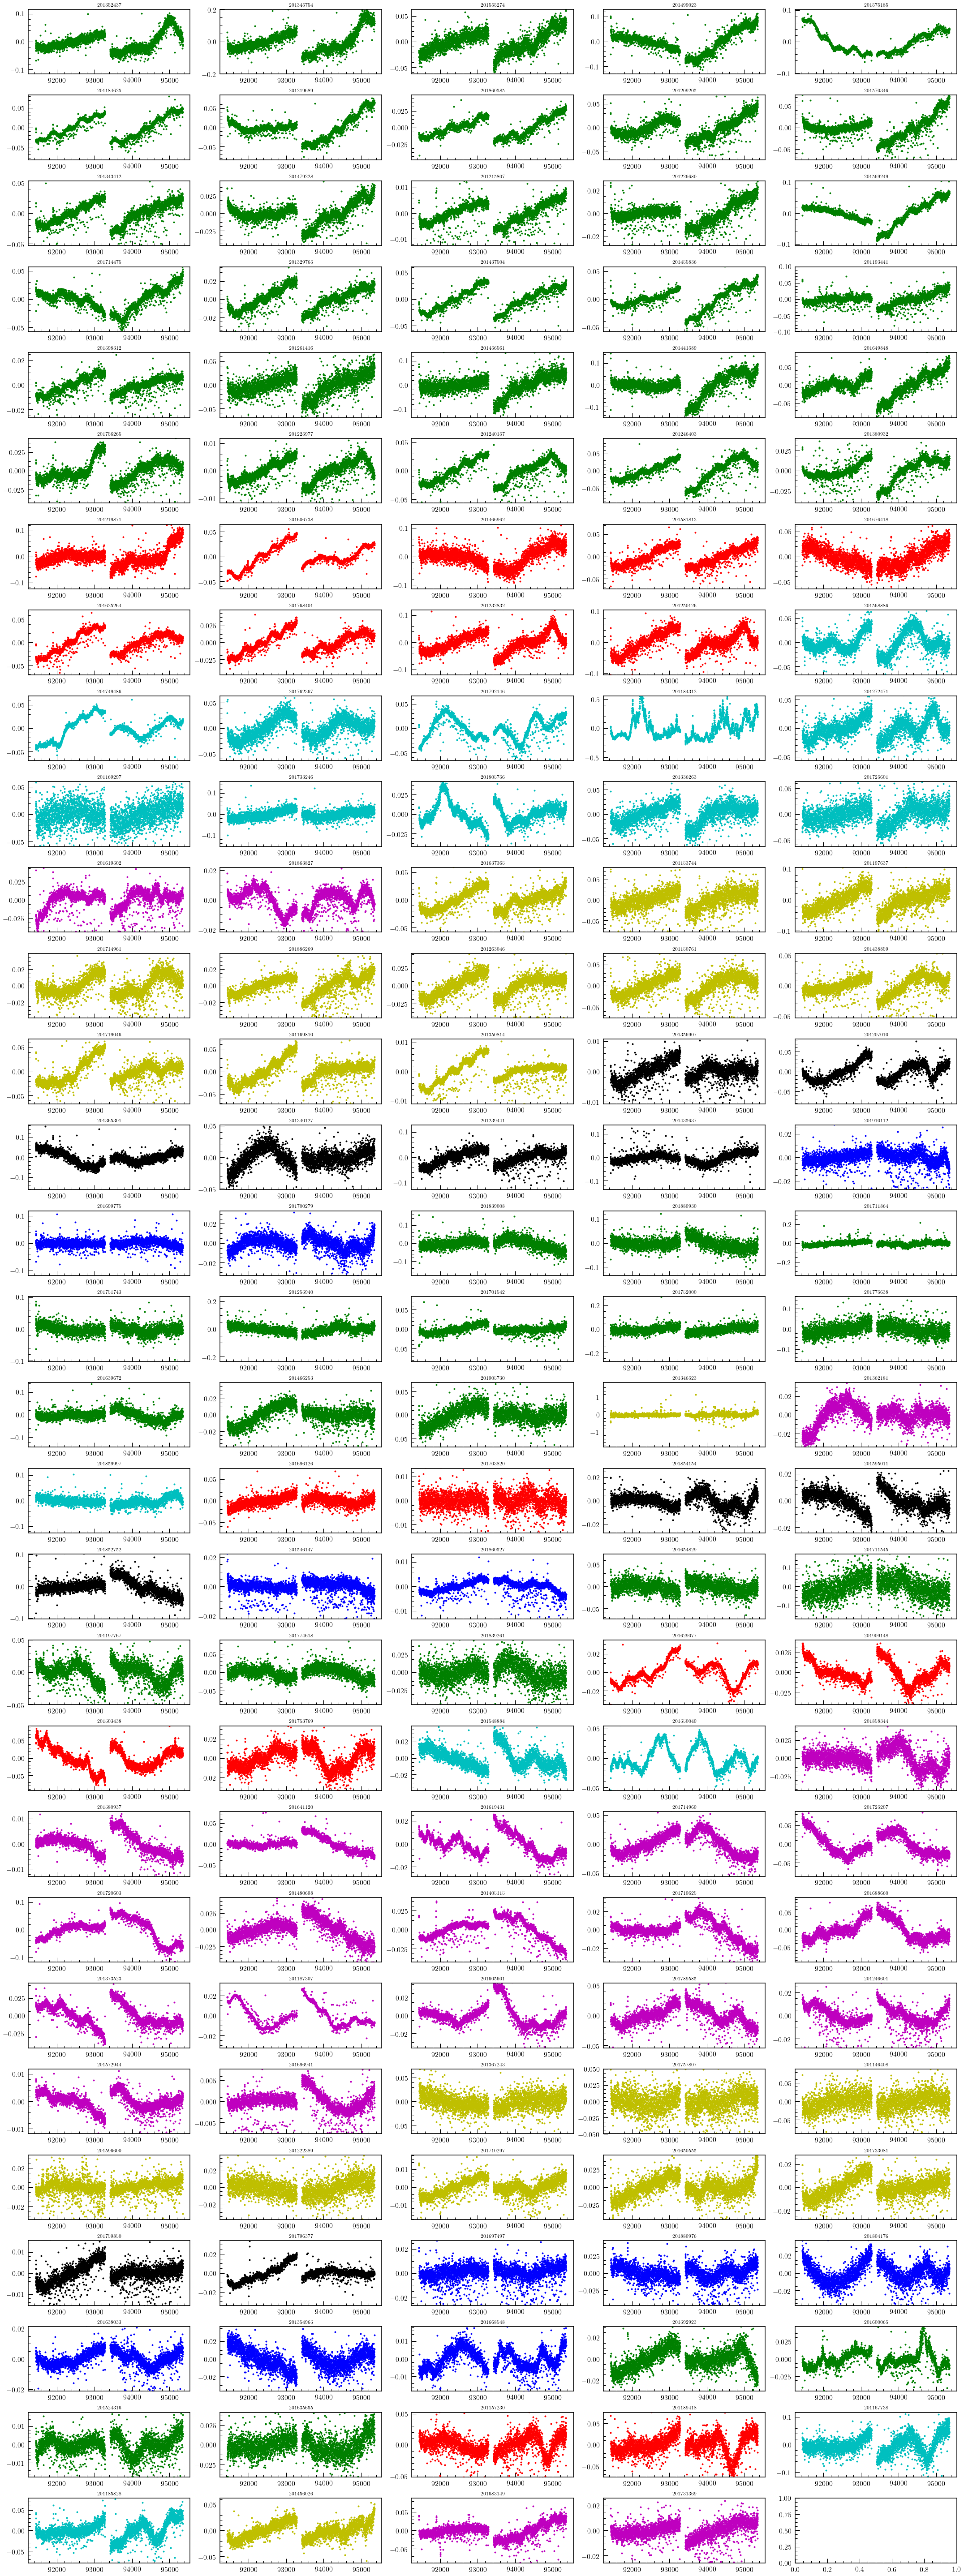

In [86]:
# plotting
numcols = 5
fig, ax = plt.subplots(nrows=150/numcols, ncols=numcols, figsize=(30,80))
colors = ['g', 'r', 'c', 'm', 'y', 'k', 'b']#, 'orange', 'grey', 'pink']

for i, index in enumerate(dend['leaves']):
    cad = sff_df['cad'][index]
    flux = sff_df['flux'][index]
    c = colors[(clusters[index]-1)%len(colors)]
    
    #  plotting
    ax[i//numcols, i%numcols].plot(cad, flux, marker='.', ls =' ', c=c, label=clusters[index])
    ax[i//numcols, i%numcols].set_title(epic_ids[index])
    ax[i//numcols, i%numcols].set_ylim(np.mean(flux)-3*np.std(flux), np.mean(flux)+3*np.std(flux))

plt.tight_layout()

### Cross correlation of the running average (?)
We're not having much luck clustering, I think it might have to do with the spread/noise in the data. So I'm going to try, instead, calculating the cross correlation based on the running average rather than the actual data. 

In [162]:
def run_avg(x, y, n=10):
    '''
    Function to calculate the running average of given data (for n data points)
    '''
    
    x_new = x[n/2:-n/2]
    y_new = np.zeros(np.shape(y[n/2:-n/2]))
    for i, val in enumerate(y):
        if i < n/2 or len(y)-i <= n/2: pass
        else: y_new[i - n/2] = np.mean(y[i - n/2: i+n/2])
    
    return x_new, y_new

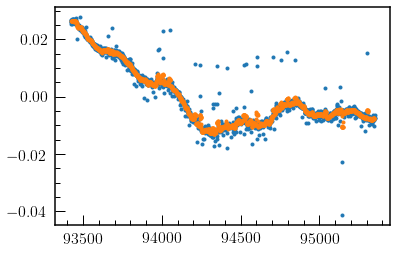

In [163]:
# a test case
x,y = run_avg(sff_df['cad post'][10], sff_df['flux post'][10])

plt.plot(sff_df['cad post'][10], sff_df['flux post'][10], marker='.', ls=' ')
plt.plot(x,y, marker='.', ls=' ')

Looks pretty good, so let's try performing a running average in our correlation calculation.

In [166]:
# add running average version to dataframe so I don't need to worry about doing it twice
avg_c = []
avg_f = []

# loop over data
for i, row in sff_df.iterrows():
    # calculate running avg
    c, f = run_avg(row['cad post'], row['flux post'])
    # save
    avg_c.append(c)
    avg_f.append(f)

# add the cols to the dataframe
if 'cad avg post' not in sff_df.columns:
    sff_df.insert(loc = len(sff_df.columns), column = 'cad avg post', value = avg_c)
    sff_df.insert(loc = len(sff_df.columns), column = 'flux avg post', value = avg_f)
else: # or just update them if they already exist
    sff_df['cad avg post'] = avg_c
    sff_df['flux avg post'] = avg_f

In [171]:
# put all the correlation coefficients in a matrix
corr_all = np.zeros((len(sff_files), len(sff_files)))

# forgive me god, for all these damn for loops
for i, row0 in sff_df.iterrows():
    
    # extract flux values after discontinuity
    flux0 = row0['flux avg post']
    
    for j, row1 in sff_df.iterrows():
        
        # extract flux values after discontinuity
        flux1 = row1['flux avg post']
        
        # calculate correlation
        #corr = pd.DataFrame(flux0)[0].corr(pd.DataFrame(flux1)[0], method='spearman')
        
        # calculate the maximum value of cross correlation
        corr = np.max(norm_xcorr(flux0, flux1))
        
        # write to matrix
        corr_all[i,j] = corr

# sanity check (there should be 1's on the diagonal)
print(corr_all)

[[1.         0.63423027 0.64245043 ... 0.32007303 0.3543417  0.26519901]
 [0.63423027 1.         0.88472051 ... 0.33290374 0.57467595 0.3256323 ]
 [0.64245043 0.88472051 1.         ... 0.31480526 0.55440718 0.30986998]
 ...
 [0.32007303 0.33290374 0.31480526 ... 1.         0.36289752 0.35359602]
 [0.3543417  0.57467595 0.55440718 ... 0.36289752 1.         0.30828677]
 [0.26519901 0.3256323  0.30986998 ... 0.35359602 0.30828677 1.        ]]


### Clustering again!

In [186]:
# generate the linkage matrix
Z = linkage(corr_all, method='average') 

# check how well it performed using Cophenetic corr coeff (closer to 1 is better)
coph, coph_dists = cophenet(Z, pdist(corr_all))
print ("Cophenetic Correlation coefficient = %s" %coph)

# set threshold for clustering
threshold = 1.5

# get clusters
clusters = fcluster(Z, threshold, criterion='distance', depth=8)
print ("Found %s different light curve groups."%len(np.unique(clusters)))

Cophenetic Correlation coefficient = 0.8363497754513305
Found 29 different light curve groups.


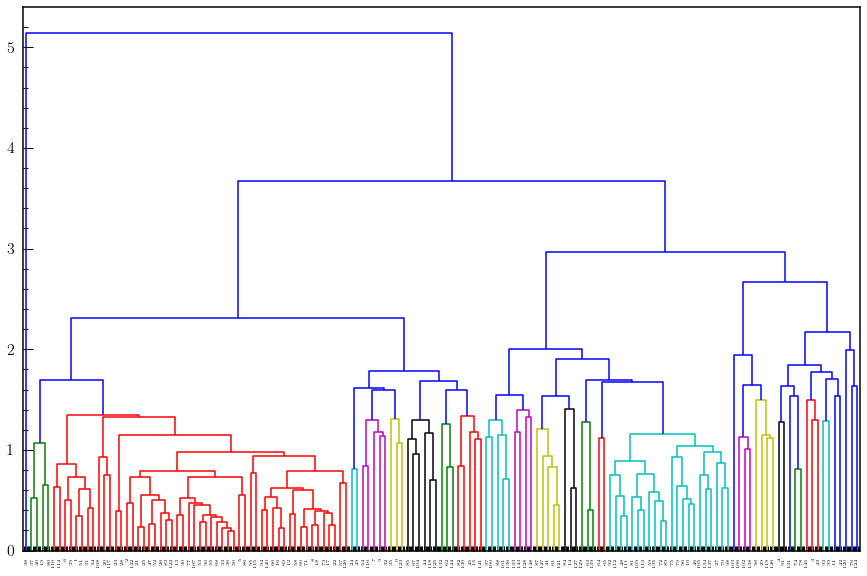

In [187]:
fig, axs = plt.subplots(figsize=(15, 10))

dend = dendrogram(Z, ax = axs, color_threshold=threshold)

The dendrogram show us what our groups look like for a given threshold. Plot them in these different groups where groups are distinguishable by color. 

**Note 1:** The plots below are of the data after the mid campaign gap. 

**Note 2:** The plotted colors do *not* necessarily correspond to the ones in the dendrogram.

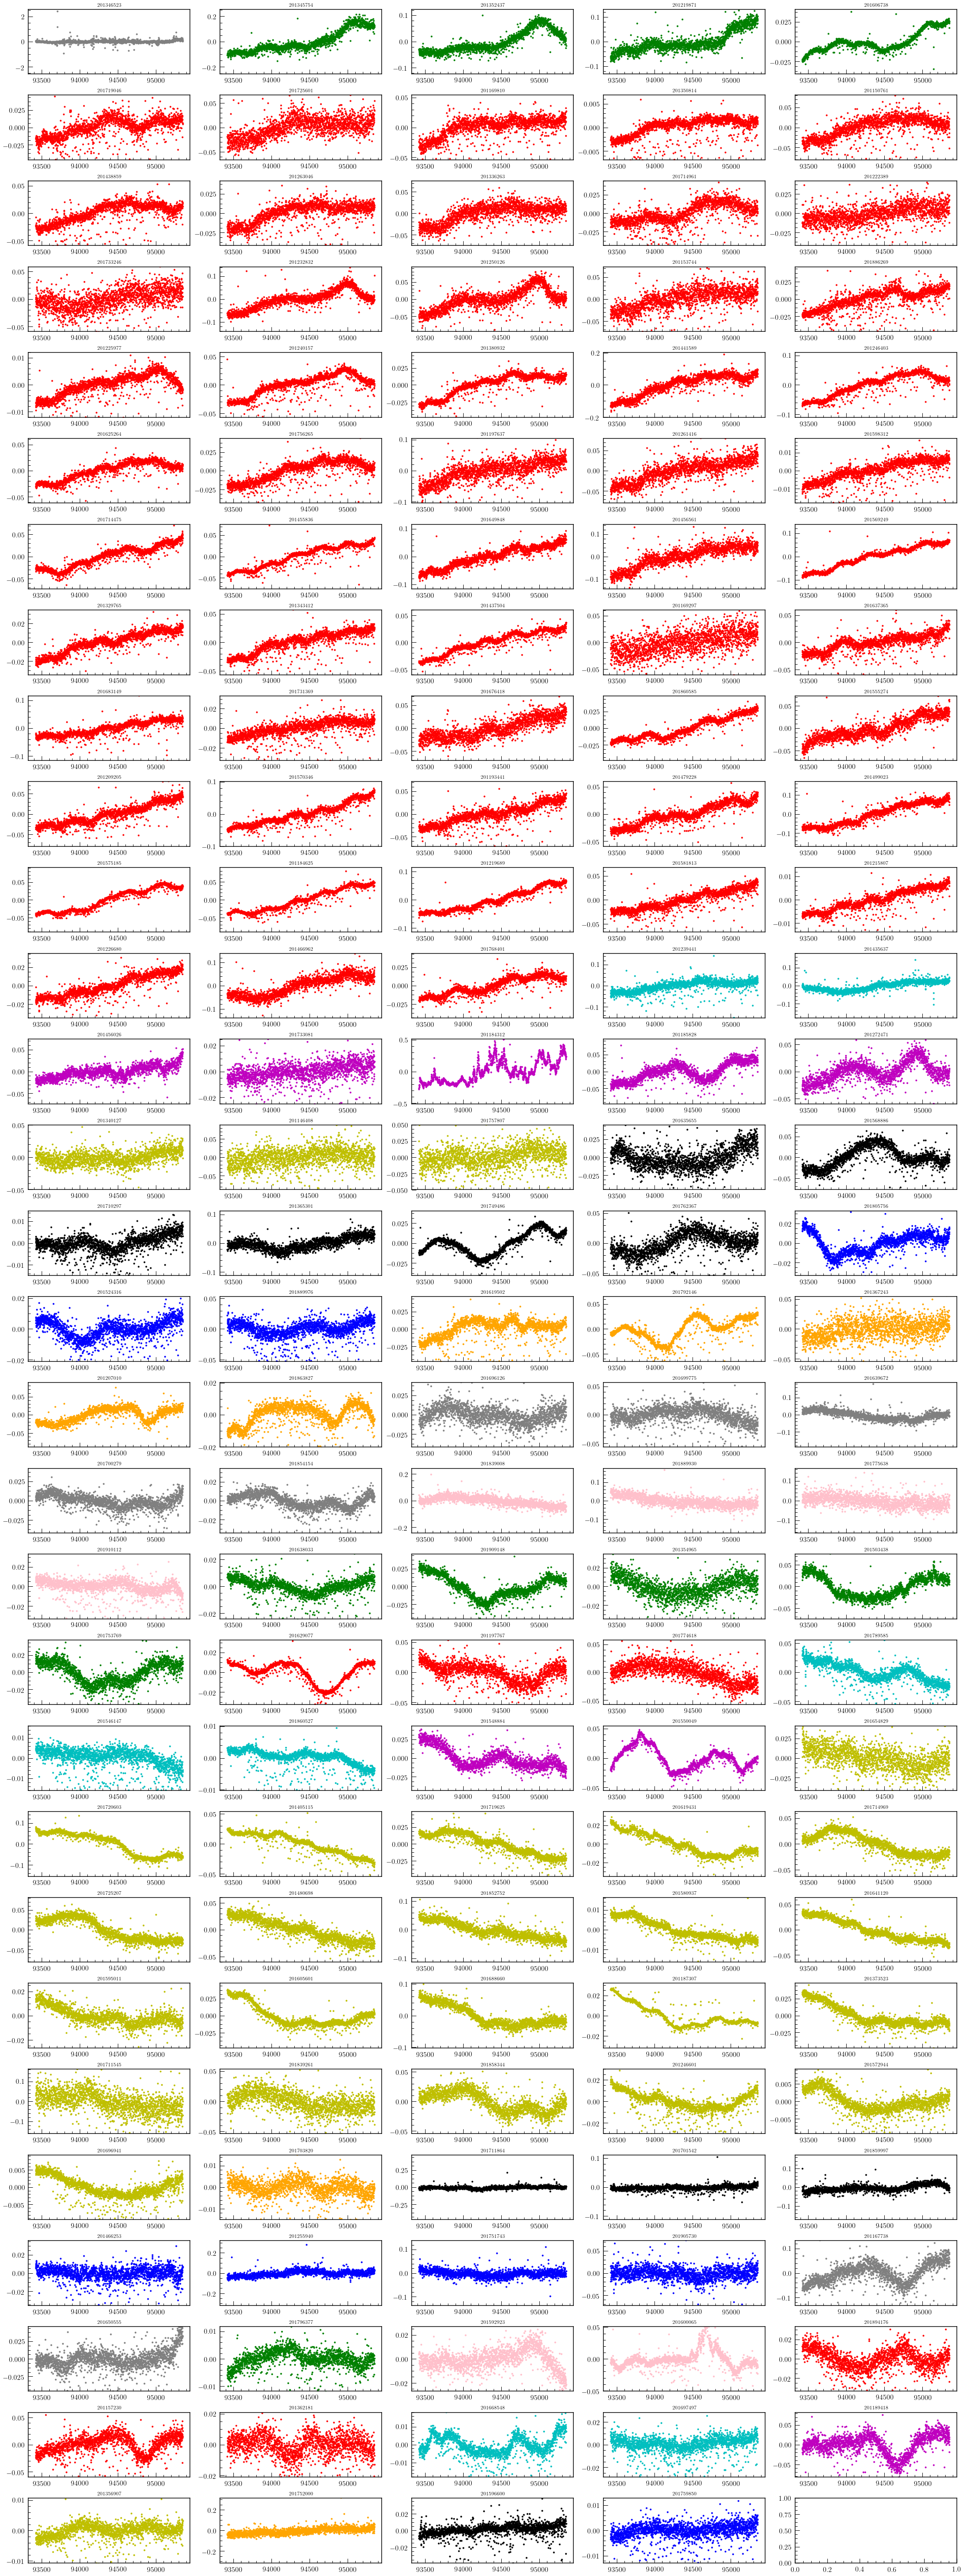

In [188]:
# plotting
numcols = 5
fig, ax = plt.subplots(nrows=150/numcols, ncols=numcols, figsize=(30,80))
colors = ['g', 'r', 'c', 'm', 'y', 'k', 'b', 'orange', 'grey', 'pink']

for i, index in enumerate(dend['leaves']):
    cad = sff_df['cad post'][index]
    flux = sff_df['flux post'][index]
    c = colors[(clusters[index]-1)%len(colors)]
    
    #  plotting
    ax[i//numcols, i%numcols].plot(cad, flux, marker='.', ls =' ', c=c, label=clusters[index])
    ax[i//numcols, i%numcols].set_title(epic_ids[index])
    ax[i//numcols, i%numcols].set_ylim(np.mean(flux)-3*np.std(flux), np.mean(flux)+3*np.std(flux))

plt.tight_layout()